# Histogram of Oriented Gradients
In this notebook, I will figure out how to use HOG features to supplement the color histogram features that I am currently using to classify image patches. HOG features are potentially useful both for identifying candidate regions and for classifying candidate regions.

In [1]:
import numpy as np
from time import time
from skimage.feature import hog
from skimage import data, color, exposure
import matplotlib.pyplot as plt
from IPython import display
import cv2

%matplotlib inline

In [2]:
imageDir = '../images/'
testDir = imageDir + 'test_images/'
test1Fn = testDir + 'test1.png'
templateDir = imageDir + 'templates/'
template1Fn = templateDir + 'template1.png'

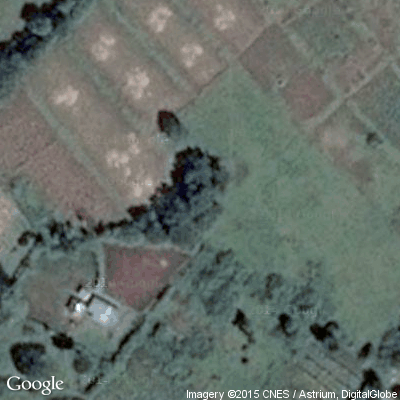

In [3]:
# Display test image 1
display.Image(filename=test1Fn)

First things first, let's just try to extract the HOG feature vector for the whole image:

In [4]:
test1 = cv2.imread(test1Fn)

In [5]:
# Convert to grayscale
test1 = cv2.cvtColor(test1, cv2.COLOR_BGR2GRAY)

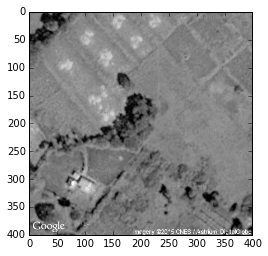

In [6]:
plt.imshow(test1, cmap=plt.cm.Greys_r)

In [15]:
# Extract Histogram of Oriented Gradients
orientations = 9
pixels_per_cell = (8,8)
cells_per_block = (3,3)
visualise = True
normalise = False
%time (test1_hog, test1_hog_image) = hog(test1, orientations=orientations,\
                                   pixels_per_cell=pixels_per_cell,\
                                   cells_per_block=cells_per_block,\
                                   visualise=visualise,\
                                   normalise=normalise)

CPU times: user 398 ms, sys: 9.79 ms, total: 408 ms
Wall time: 392 ms


In [9]:
test1_hog.shape

(186624,)

In [10]:
test1_hog_image.shape

(400, 400)

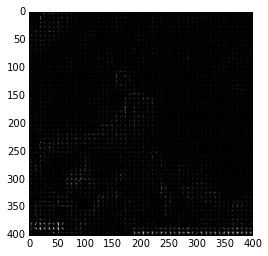

In [11]:
plt.imshow(test1_hog_image, cmap=plt.cm.Greys_r)

Let's quickly run through the tutorial provided in the scikit-image docs about plotting HoG features. [link](http://scikit-image.org/docs/dev/auto_examples/plot_hog.html)

In [12]:
# Loading a 512x512x3 color picture
image = color.rgb2gray(data.astronaut())
image = image[:512,:512]

In [14]:
# Computing hog features
%time fd, hog_image = hog(image, orientations=9, pixels_per_cell=(8,8),\
                          cells_per_block=(3,3), visualise=True)

CPU times: user 659 ms, sys: 12.9 ms, total: 671 ms
Wall time: 657 ms


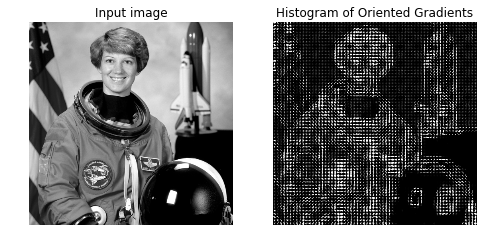

In [74]:
# Plotting original image and gradients
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.axis('off')
ax1.imshow(image, cmap=plt.cm.gray)
ax1.set_title('Input image')

# Rescale histogram for better display
hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0,0.02))

ax2.axis('off')
ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
ax2.set_title('Histogram of Oriented Gradients')
plt.show()

In [142]:
hog_image.shape

(512, 512)

In [75]:
fd.shape

(311364,)

In [76]:
# Pixels per cell
ppc = 64
# Cells per block
cpb = 9
# Bins per histogram
bins = 9
# Blocks per dimension
bpd = 512 / 8 - 2
bpd
# Bins per block
bpb = bins * cpb
bpb
# Total bins
total = bpd ** 2 * bpb
total

311364

## Histogram of oriented gradients implementation
Let's try to implement our own HOG function where we can input an image or image patch and return the HOG vector. This would be a very basic feature to add to the color histogram vector for roof classification, or we can get fancier and have blocks of cells, normalization, etc.

### Image convolution with kernel
The first thing we will need to do is figure out how to convolve a given image (array) with a kernel. This will allow us to efficiently take the gradient of each image.

(-0.5, 4.5, 4.5, -0.5)

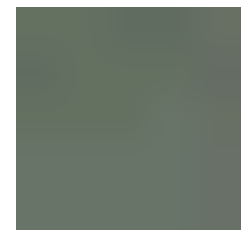

In [192]:
# Load in small test image
test1 = cv2.imread(test1Fn)
patch1 = test1[:5,:5,:]
# Display small image patch
plt.imshow(patch1)
plt.axis('off')

In [90]:
print patch1[:,:,0]
print patch1[:,:,1]
print patch1[:,:,2]

[[100 100  96  96 104]
 [ 96 100 100 100 100]
 [100 100 100 104 104]
 [104 104 104 104 104]
 [104 104 104 104 104]]
[[113 113 108 108 112]
 [108 113 113 113 108]
 [113 113 113 116 112]
 [116 116 116 116 112]
 [116 116 116 116 112]]
[[ 97  97  96  96 100]
 [ 96  97  97  97 100]
 [ 97  97  97 104 100]
 [104 104 104 104 104]
 [104 104 104 104 104]]


To compute the image gradients by convolving with $[1, 0, -1]$ and $[1, 0, -1]^T$ arrays, we first need to pad our image patch. For now, I'll choose to pad the array with its edge values.

In [98]:
# Padding image patch by 1 pixel in each of the first two dimensions
# Don't pad in the 3rd (color channel) dimension
patch1pad = np.pad(patch1, ((1,1), (1,1), (0,0)), 'edge')
print patch1pad.shape

(7, 7, 3)


Now we're ready to convolve with our gradient kernels to calculate the image gradient at each pixel. Let's start with the first channel:

In [106]:
from scipy.ndimage import filters

In [132]:
# Select the first padded color channel
channel1pad = patch1pad[:,:,0]
# Convert to signed int
channel1pad = channel1pad.astype(np.int_)

In [133]:
# Horizontal convolution kernel
horiz_kernel = np.array([[1, 0, -1]])

In [134]:
# Horizontal convolution
horiz1pad = filters.convolve(channel1pad, horiz_kernel, mode='reflect')

In [135]:
print channel1pad

[[100 100 100  96  96 104 104]
 [100 100 100  96  96 104 104]
 [ 96  96 100 100 100 100 100]
 [100 100 100 100 104 104 104]
 [104 104 104 104 104 104 104]
 [104 104 104 104 104 104 104]
 [104 104 104 104 104 104 104]]


In [136]:
print horiz1pad

[[ 0  0 -4 -4  8  8  0]
 [ 0  0 -4 -4  8  8  0]
 [ 0  4  4  0  0  0  0]
 [ 0  0  0  4  4  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]


Does it work without padding? It seems like padding does the same thing as what the "reflect" mode in the convolution does. Let's find out:

In [137]:
channel1 = patch1[:,:,0]
channel1 = channel1.astype(np.int_)
# Horizontal convolution
horiz1 = filters.convolve(channel1, horiz_kernel, mode='reflect')
print horiz1

[[ 0 -4 -4  8  8]
 [ 4  4  0  0  0]
 [ 0  0  4  4  0]
 [ 0  0  0  0  0]
 [ 0  0  0  0  0]]


Nice, it works just as expected. Now let's also get the vertical gradients:

In [138]:
# Vertical convolution kernel
vert_kernel = np.array([[1], [0], [-1]])

In [139]:
# Vertical convolution
vert1 = filters.convolve(channel1, vert_kernel, mode='reflect')
print vert1

[[-4  0  4  4 -4]
 [ 0  0  4  8  0]
 [ 8  4  4  4  4]
 [ 4  4  4  0  0]
 [ 0  0  0  0  0]]


### Computing gradient magnitude and direction
The next thing to do is to use our vertical and horizontal derivatives to compute the gradient magnitude and direction. We can do this by using writing a function that converts cartesian coordinates to polar coordinates.

In [147]:
# Create arrays for magnitude and direction
mag1 = np.zeros(channel1.shape)
dir1 = np.zeros(channel1.shape)

In [153]:
# Function to convert from cartesian to polar coordinates
def cart2pol(x, y):
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y, x)
    return (rho, phi)

In [277]:
# Compute magnitude and direction for gradient at each pixel
for i in range(mag1.shape[0]):
    for j in range(mag1.shape[1]):
        mag1[i,j], dir1[i,j] = cart2pol(horiz1[i,j], vert1[i,j])
        # Converting angles to degrees and taking absolute value
        dir1[i,j] = abs(np.rad2deg(dir1[i,j]))

### Binning into histogram of gradients
To compute our histogram of gradients, we need to divide 0-180 degrees into 9 bins that are each 20 degrees wide. We also need to weight the gradients by their magnitude, and figure out some way to split their votes among bins so that gradients that are very close to the boundary between two bins do not affect the results too much.

But first, let's just try binning without splitting votes among bins.

In [188]:
# Computing simple histogram of gradients
hist1, bin_edges1 = np.histogram(dir1, bins=9, range=(0,180),\
                                 weights=mag1, density=False)
hist1 = hist1 / sum(hist1)

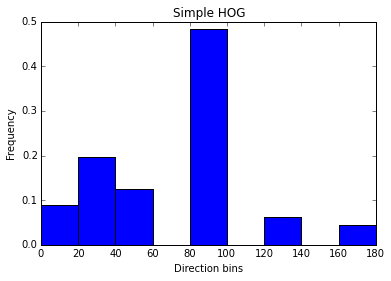

In [191]:
# Plot HOG
plt.bar(bin_edges1[:-1], hist1, width=20)
plt.title('Simple HOG')
plt.xlabel('Direction bins')
plt.ylabel('Frequency')
plt.show()

That was easy! Let's put all of this into a function that returns a (simple version of) HOG feature vector for a given image patch. One last thing that we need to add for this implementation is a calculation of the gradients for each color channel, then picking the largest in magnitude as the gradient for each pixel.

### HOG function

In [269]:
import numpy as np

def compute_hog(image_patch):
    """
    This function takes an image patch as input and returns a 9-element
    vector containing the histogram of oriented gradients.
    :param image_patch: The image patch on which to compute the HOG
    :returns: The HOG feature vector and the edges of the bins
    """
    # Converting to signed integer
    image_patch = image_patch.astype(np.int_)
    height = image_patch.shape[0]
    width = image_patch.shape[1]
    
    # Compute gradients for each channel
    if len(image_patch.shape) > 2:
        channels = image_patch.shape[2]
        magnitude = np.zeros((height, width, channels))
        direction = np.zeros((height, width, channels))
        for i in range(channels):
            magnitude[:,:,i], direction[:,:,i] = compute_gradient(image_patch[:,:,i])
        # Select maximum gradient from all channels at each pixel
        max_index = np.argmax(magnitude, axis=2)
        max_magnitude = np.zeros((height, width))
        max_direction = np.zeros((height, width))
        for i in range(height):
            for j in range(width):
                max_magnitude[i,j] = magnitude[i,j,max_index[i,j]]
                max_direction[i,j] = direction[i,j,max_index[i,j]]
    
    # If only one channel
    else:
        max_magnitude, max_direction = compute_gradient(image_patch)
    
    
    # Computing simple histogram of gradients
    hist, bin_edges = np.histogram(max_direction, bins=9, range=(0,180),\
                                     weights=max_magnitude, density=False)
    hist = hist / sum(hist)
    return (hist, bin_edges)

In [1]:
import numpy as np
from scipy.ndimage import filters

def compute_gradient(channel):
    """
    This function computes the gradient magnitudes and directions for one
    channel of an image patch.
    :param channel: One channel of an image patch
    :returns: Magnitude and direction arrays of the same dimensions as the
    input channel of the image patch
    """
    # Convolution kernels
    horiz_kernel = np.array([[1, 0, -1]])
    vert_kernel = np.array([[1], [0], [-1]])
    
    # Compute horizontal and vertical components of gradient
    horiz = filters.convolve(channel, horiz_kernel, mode='reflect')
    vert = filters.convolve(channel, vert_kernel, mode='reflect')
    
    # Create arrays for magnitude and direction
    magnitude = np.zeros(channel.shape)
    direction = np.zeros(channel.shape)
    
    # Compute magnitude and direction for gradient at each pixel
    for i in range(channel.shape[0]):
        for j in range(channel.shape[1]):
            magnitude[i,j], direction[i,j] = cart2pol(horiz[i,j], vert[i,j])
            # Converting angles to degrees and taking modulo 180
            direction[i,j] = np.rad2deg(direction[i,j]) % 180
    
    # Return computed gradient
    return (magnitude, direction)

Let's test out the HOG function, first on the single channel that we did earlier so that we can compare, then on a 3-channel image patch.

In [273]:
(hist1, bin_edges1) = compute_hog(channel1)

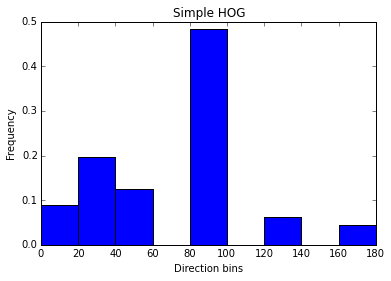

In [274]:
# Plot HOG
plt.bar(bin_edges1[:-1], hist1, width=20)
plt.title('Simple HOG')
plt.xlabel('Direction bins')
plt.ylabel('Frequency')
plt.show()

Let's see how long it takes to run for a 400x400x3 image:

In [280]:
t0 = time()
(hist1_all, bin_edges1_all) = compute_hog(test1)
t1 = time()
print 'One satellite image takes {} seconds.'.format(t1-t0)

One satellite image takes 2.43105816841 seconds.


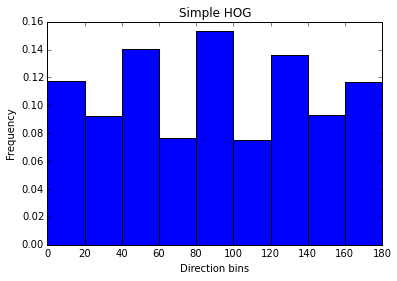

In [281]:
# Plot HOG
plt.bar(bin_edges1_all[:-1], hist1_all, width=20)
plt.title('Simple HOG')
plt.xlabel('Direction bins')
plt.ylabel('Frequency')
plt.show()